**Adding libraries and dependencies**

In [4]:
import numpy as np
import tensorflow as tf

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.base_env import ActionTuple

import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import array_spec
from tf_agents.policies import policy_saver
from tf_agents.agents.ppo import ppo_agent
from tf_agents.networks import actor_distribution_network, value_network
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

Checking GPU detection

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Establishing connection with Unity environment**

In [27]:
env.close()

In [28]:
engine_config_channel = EngineConfigurationChannel()

env = UnityEnvironment(
    file_name=None,
    worker_id=0,
    base_port=5004,
    side_channels=[engine_config_channel],
    timeout_wait=36000
)

In [29]:
env.reset()
behavior_names = list(env.behavior_specs)
behavior_name = behavior_names[0]
behavior_spec = env.behavior_specs[behavior_name]

print(f"Behavior: {behavior_name}")
print(f"Action branches: {behavior_spec.action_spec.discrete_branches}")
print(f"Observation shapes: {[obs.shape for obs in behavior_spec.observation_specs]}")

decision_steps, terminal_steps = env.get_steps(behavior_name)
print(f"Active agents: {len(decision_steps)}")

Behavior: Robot?team=0
Action branches: (5,)
Observation shapes: [(45,), (12,)]
Active agents: 1


#### **Action Space**
- **5 discrete actions** corresponding to possible movements:
  - `0`: Do nothing
  - `1`: Go right  
  - `2`: Go left
  - `3`: Go forward
  - `4`: Go backwards

#### **Observation Space**

##### Ray Perception (45 dimensions)
- **45 values** from ML-Agents Ray Perception Sensor 3D component
- Detects tags and distances in the environment. It detects the tags: Floor, GoodSphere, Badsphere. The Sensor contains 9 rays, each contains these following 5 observations:
  - GoodSphere: `0` not detected, `1` detected
  - BadSphere: `0` not detected, `1` detected
  - Floor: `0` not detected, `1` detected
  - No-hit flag: `1` didn't detect anything, `1` detected something
  - Distance: varies from `0`(close) to `1`(far)

##### Agent State (12 dimensions)
- **12 normalized values** divided as follows:
  - Position: `x`, `z` coordinates
  - Velocity: `x`, `z` velocity components  
  - Rotation: 4 one-hot encoded values `forward` `backwards` `left` `right`
  - Distances to floor bounds: `top`, `bottom`, `right`, `left` 

**Total observation size:** 57

---

In [7]:
action_size = 5
state_size = 57

Preparing a get_state function for model training and inference, that is responsible for getting the agent's state at the current step and returning information which will later be used by the model :
- state (57,) : agent's state at the current step
- reward (float) : reward of the current step
- done (boolean) : whether the episode is terminated at the current step

In [8]:
def get_state():
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    
    if len(decision_steps) > 0:
        obs1 = decision_steps.obs[0][0] #Ray perception sensor observations
        obs2 = decision_steps.obs[1][0] #Agent state observations
        state = np.concatenate([obs1, obs2]) #Combine observations for correct DQN input format
        return state, decision_steps.reward[0], False
    
    elif len(terminal_steps) > 0:
        # Episode ended
        obs1 = terminal_steps.obs[0][0]
        obs2 = terminal_steps.obs[1][0] 
        state = np.concatenate([obs1, obs2])
        return state, terminal_steps.reward[0], True
    
    return None, 0, False


**Making a random Neural Network for testing Model-Simulation connection**

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(state_size,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14848     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 311301 (1.19 MB)
Trainable params: 311301 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
l1_weights = model.get_weights()[0]
l1_weights[:,0] #weights of the first neuron of the first layer

array([ 0.07737374, -0.00648218,  0.06949984,  0.03705293, -0.06775721,
        0.1202559 ,  0.12113152, -0.01201017, -0.08666   ,  0.07665624,
       -0.01725511,  0.09428237, -0.07929844,  0.09896681, -0.05624677,
       -0.11420877,  0.12827615, -0.03118309, -0.00405595, -0.09832588,
        0.11950238,  0.03512914, -0.0148273 ,  0.01080281, -0.13288987,
       -0.09832539,  0.06312427, -0.03498427,  0.04186118,  0.01500417,
       -0.09339771, -0.1320627 ,  0.09191471,  0.07503961, -0.13829374,
        0.11795633,  0.12565921,  0.12211533, -0.07425632, -0.08830254,
        0.00774524, -0.09108131,  0.12355249,  0.0578333 ,  0.05846249,
       -0.10532427, -0.07864448, -0.00682013,  0.01125669, -0.03624759,
        0.03209838, -0.06470561,  0.12328513, -0.05323479,  0.01460478,
       -0.03497186, -0.01957263], dtype=float32)

Running the model with the initial random weights

In [10]:
for step in range(100): #Run for 100 steps
    state, reward, done = get_state()
    
    if state is not None:
        if done:
            env.reset()
        q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
        action = np.argmax(q_values[0])  # Choose best action
        
        if step % 10 == 0: 
            print(f"Step {step}: Action {action}, Reward {reward:.2f}")
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()
    else:
        env.close()
    

2025-08-21 03:34:35.346872: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Step 0: Action 3, Reward 0.00
Step 10: Action 3, Reward 0.00
Step 20: Action 3, Reward 0.00
Step 30: Action 3, Reward 0.00
Step 40: Action 3, Reward 0.00
Step 50: Action 3, Reward 0.00
Step 60: Action 3, Reward 0.00
Step 70: Action 3, Reward 0.00
Step 80: Action 3, Reward 0.00
Step 90: Action 3, Reward 0.00


**Creating environment wrapper for TF agents**

In [9]:
class EnvironmentWrapper(py_environment.PyEnvironment):
    def __init__(self, unity_env, behavior_name, get_state_func):
        super().__init__()
        self.unity_env = unity_env
        self.behavior_name = behavior_name
        self.get_state_func = get_state_func

        self._action_spec = array_spec.BoundedArraySpec(
            shape=(),
            dtype=np.int32,
            minimum=0,
            maximum=4,
            name='action'
        )
        self._observation_spec = array_spec.ArraySpec(
            shape=(state_size,),
            dtype=np.float32,
            name='observation'
        )

        self._state = np.zeros(state_size, dtype=np.float32)
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.unity_env.reset()
        self._episode_ended = False
        state, _, _ = self.get_state_func()
        if state is not None:
            self._state = state.astype(np.float32)
        return tf_agents.trajectories.time_step.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        self.unity_env.set_actions(self.behavior_name, action_tuple)
        self.unity_env.step()
        
        # Get new state
        state, reward, done = self.get_state_func()

        if state is not None:
            self._state = state.astype(np.float32)
        
        if done:
            self._episode_ended = True
            return tf_agents.trajectories.time_step.termination(self._state, reward)
        else:
            return tf_agents.trajectories.time_step.transition(self._state, reward)

### **Creating and training the agent**
We are going to use Proximal Policy Optimization (PPO) for creating the agent, the reward are going to be as follows:
- Falling: -10
- Doing nothing: -0.01 (encouraging movement)
- Collecting green sphere: +3
- Collecting red sphere: -3
- Distance to green sphere: +(0.005 x (1-Distance)) for each ray that is detecting a green sphere  
- Distance to red sphere: -(0.005 x (1-Distance)) for each ray that is detecting a red sphere  

Creating a new environment wrapper

In [ ]:
engine_config_channel = EngineConfigurationChannel()

env = UnityEnvironment(
    file_name=None,
    worker_id=0,
    base_port=5004,
    side_channels=[engine_config_channel],
    timeout_wait=36000
)

In [31]:
env_wrapper_ppo = EnvironmentWrapper(env, behavior_name, get_state)
tf_env_ppo = tf_py_environment.TFPyEnvironment(env_wrapper_ppo)

Creating actor and critic networks

In [11]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    tf_env_ppo.observation_spec(),
    tf_env_ppo.action_spec(),
    fc_layer_params=(256, 128, 64)
)

value_net = value_network.ValueNetwork(
    tf_env_ppo.observation_spec(),
    fc_layer_params=(256, 128, 64)
)

Creating the agent

In [12]:
train_step_counter_ppo = tf.Variable(0)

ppo = ppo_agent.PPOAgent(
    tf_env_ppo.time_step_spec(),
    tf_env_ppo.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    normalize_observations=False,
    normalize_rewards=True,
    use_gae=True,
    lambda_value=0.95,
    entropy_regularization=0.02,
    importance_ratio_clipping=0.2,
    discount_factor=0.99,
    value_pred_loss_coef=0.5,
    num_epochs=3,
    train_step_counter=train_step_counter_ppo,
)

ppo.initialize()

2025-08-22 15:05:17.594400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-22 15:05:17.781952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-22 15:05:17.782003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-22 15:05:17.785077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-22 15:05:17.785119: I external/local_xla/xla/stream_executor

Creating the replay buffer

In [13]:
replay_buffer_ppo = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=ppo.collect_data_spec,
    batch_size=tf_env_ppo.batch_size,
    max_length=20000,
)

In [14]:
def rb_observer(traj):
    replay_buffer_ppo.add_batch(traj)

driver = DynamicEpisodeDriver(
    tf_env_ppo,
    ppo.collect_policy,
    observers=[rb_observer],
    num_episodes=10,
)

In [15]:
num_iterations_ppo = 1500
eval_interval_ppo = 10
speed_ppo = 100

In [17]:
eval_returns = []

engine_config_channel.set_configuration_parameters(time_scale=speed_ppo)

for iteration in range(num_iterations_ppo):
    replay_buffer_ppo.clear()
    driver.run()

    experience = replay_buffer_ppo.gather_all()
    loss_info = ppo.train(experience)
    replay_buffer_ppo.clear()

    if iteration % eval_interval_ppo == 0:
        ts = tf_env_ppo.reset()
        step_count = 0
        eval_return = 0.0

        while not ts.is_last():
            action_step = ppo.policy.action(ts)
            step_count += 1
            ts = tf_env_ppo.step(action_step.action)
            eval_return += ts.reward

        eval_returns.append(eval_return.numpy()[0])
        print(f"Iter {iteration} | Eval return: {eval_return.numpy()[0]:.2f} | Steps: {step_count}")


print('Training complete!')

Iter 0 | Eval return: -6.51 | Steps: 21
Iter 10 | Eval return: 3.03 | Steps: 50
Iter 20 | Eval return: 4.85 | Steps: 46
Iter 30 | Eval return: 7.75 | Steps: 42
Iter 40 | Eval return: -36.03 | Steps: 400
Iter 50 | Eval return: 12.29 | Steps: 400
Iter 60 | Eval return: 36.39 | Steps: 400
Iter 70 | Eval return: 31.05 | Steps: 400
Iter 80 | Eval return: 27.56 | Steps: 400
Iter 90 | Eval return: -14.51 | Steps: 400
Iter 100 | Eval return: 90.52 | Steps: 400
Iter 110 | Eval return: 49.25 | Steps: 400
Iter 120 | Eval return: 19.71 | Steps: 400
Iter 130 | Eval return: 27.45 | Steps: 400
Iter 140 | Eval return: 33.60 | Steps: 400
Iter 150 | Eval return: 66.55 | Steps: 400
Iter 160 | Eval return: 61.30 | Steps: 400
Iter 170 | Eval return: 95.64 | Steps: 400
Iter 180 | Eval return: 84.09 | Steps: 400
Iter 190 | Eval return: 41.30 | Steps: 400
Iter 200 | Eval return: 54.03 | Steps: 400
Iter 210 | Eval return: 2.30 | Steps: 400
Iter 220 | Eval return: 113.59 | Steps: 400
Iter 230 | Eval return: -2.

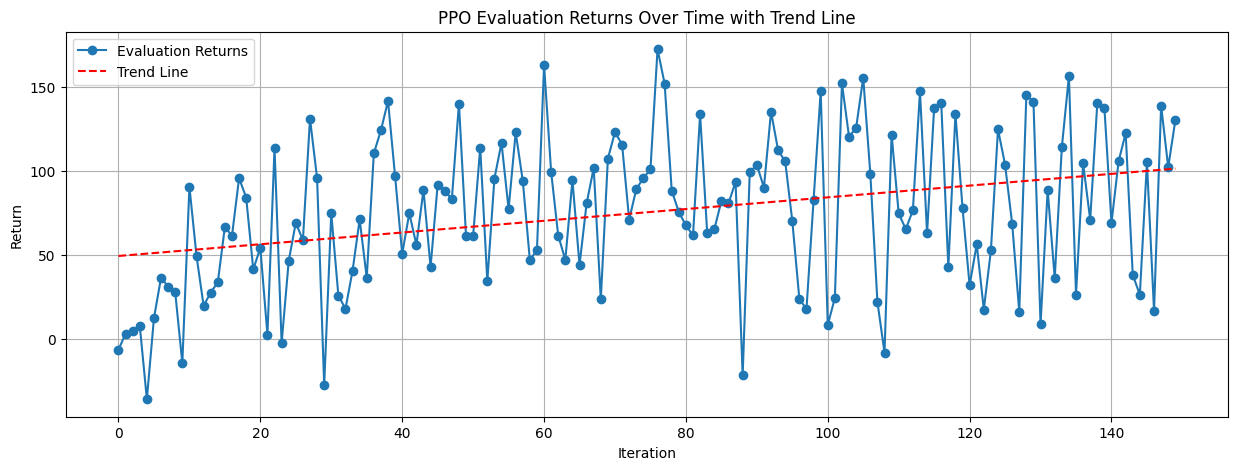

In [25]:
fig = plt.figure(figsize=(15, 5))

plt.plot(eval_returns, label='Evaluation Returns', marker='o')

x = np.arange(len(eval_returns))
coefficients = np.polyfit(x, eval_returns, 1)
trend_line = np.polyval(coefficients, x)
plt.plot(x, trend_line, label='Trend Line', linestyle='--', color='red')

plt.title('PPO Evaluation Returns Over Time with Trend Line')
plt.xlabel('Iteration')
plt.ylabel('Return')
plt.legend()
plt.grid(True)

plt.show()

In [23]:
ppo_policy_saver = policy_saver.PolicySaver(ppo.policy)
ppo_policy_saver.save('./saved_models/ppo_agent')

checkpoint = tf.train.Checkpoint(
    actor_net=ppo._actor_net,
    value_net=ppo._value_net,
    optimizer=ppo._optimizer,
    train_step=ppo._train_step_counter
)
checkpoint.save('./checkpoints/ppo_checkpoint')

INFO:tensorflow:Assets written to: ./saved_models/ppo_agent/assets


/home/louay/miniforge3/envs/DQL_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: ./saved_models/ppo_agent/assets


'./checkpoints/ppo_checkpoint-1'

Model evaluation

*For these episodes of evaluation, we will remove the reward for getting closer to spheres to be able to easily track the number of spheres collected*

In [ ]:
ppo_total_returns = []
ppo_total_steps = []

engine_config_channel.set_configuration_parameters(time_scale=2)
for episode in range(10):
    time_step = tf_env_ppo.reset()
    episode_return = 0.0
    steps_in_episode = 0
    green_spheres = 0
    red_spheres = 0

    while not time_step.is_last():
        action_step = ppo.policy.action(time_step)
        time_step = tf_env_ppo.step(action_step.action)
        episode_return += time_step.reward
        steps_in_episode += 1
        if time_step.reward == 3:
            green_spheres += 1
        elif time_step.reward == -3:
            red_spheres += 1

    ppo_total_returns.append(episode_return.numpy()[0])
    ppo_total_steps.append(steps_in_episode)
    print(f"Episode {episode+1}: Return = {episode_return.numpy()[0]:.2f}, Steps = {steps_in_episode}, Green Spheres = {green_spheres}, Red Spheres = {red_spheres}")

avg_return = np.mean(ppo_total_returns)
avg_steps = np.mean(ppo_total_steps)
std_return = np.std(ppo_total_returns)

print(f"Average Return: {avg_return:.2f}")
print(f"Average Episode Length: {avg_steps:.1f} steps")
print(f"Best Episode: {max(ppo_total_returns):.2f}")
print(f"Worst Episode: {min(ppo_total_returns):.2f}")

Episode 1: Return = 30.00, Steps = 400, Green Spheres = 8, Red Spheres = 0
Episode 2: Return = 84.00, Steps = 400, Green Spheres = 28, Red Spheres = 4
Episode 3: Return = 75.00, Steps = 400, Green Spheres = 27, Red Spheres = 2
Episode 4: Return = 90.00, Steps = 400, Green Spheres = 38, Red Spheres = 8
Episode 5: Return = 87.00, Steps = 400, Green Spheres = 24, Red Spheres = 1
Episode 6: Return = 87.00, Steps = 400, Green Spheres = 34, Red Spheres = 7
Episode 7: Return = 93.00, Steps = 400, Green Spheres = 30, Red Spheres = 3
Episode 8: Return = 105.00, Steps = 400, Green Spheres = 36, Red Spheres = 5
Episode 9: Return = 120.00, Steps = 400, Green Spheres = 40, Red Spheres = 6
Episode 10: Return = 93.00, Steps = 400, Green Spheres = 36, Red Spheres = 9
Average Return: 86.40
Average Episode Length: 400.0 steps
Best Episode: 120.00
Worst Episode: 30.00


#### **Training Summary**
**After 23 hours of training, the agent demonstrated a solid understanding of the three main objectives:**

1. Avoiding Falls:
<br>
The agent quickly learned not to fall off the edges, achieving this behavior after 30–40 training iterations.  


2. Collecting Green Spheres:
<br>
The agent successfully learned to collect green spheres during evaluation episodes.


3. Avoiding Red Spheres:
<br>
The agent showed an understanding of avoiding red spheres.


**Despite the progress, two key issues remain:**

1. Close Proximity of Green and Red Spheres:
<br>
When a green sphere and a red sphere are close to each other, the agent collects both without optimizing its movement to avoid the red sphere.


2. Getting Stuck in Empty Areas:<br>
After collecting all nearby green spheres, the agent gets stuck in areas without any green spheres (outside its Ray Perception range). It then moves back and forth in the same spot without exploring further.

In [ ]:
env.close()